# This notebook takes a chart of all of the energy-parameters used in the fits: priors, posteriors, and theoretical values

In [1]:
import numpy as np
import gvar as gv
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

In [15]:
import pickle


In [3]:
def Ei(n_selec, p):
    Ea = p['E0']
    for l in range(1, n_selec+1):
        Ea += p['dE{}'.format(l)]
        
    #print(Ea)
    return Ea

In [4]:
def Ei_FH(n_selec, p):
    Ea = p['E0']
    for l in range(1, n_selec):
        Ea += p['dE{}'.format(l)]
        
    Ea += p['FH_dEmax']
    
    return Ea

In [5]:
# This method is copied from StackOverFlow, courtesy of tmdavison (https://stackoverflow.com/questions/37852462/filled-errorbars-in-matplotlib-rectangles/37852631)
def makeErrorBoxes(xdata,ydata,xerror,yerror,fc=None,ec='None',alpha=0.3, legendlabel=None):
    
    if fc is None:
        fc = np.array(['red' for i in xdata])
    
    # Create list for all the error patches
    errorboxes = []

    # Loop over data points; create box from errors at each point
    for xc,yc,xe,ye,ci in zip(xdata,ydata,xerror.T,yerror.T,fc):
        rect = Rectangle((xc-xe[0],yc-ye[0]),xe.sum(),ye.sum())
        errorboxes.append(rect)

    # Create patch collection with specified colour/alpha
    pc = PatchCollection(errorboxes,alpha=alpha,edgecolor=ec, facecolor=fc, label = legendlabel)
    #if legendlabel is not None:
        #pc.set_label(legendlabel)
    
    # Add collection to axes
    ax.add_collection(pc)
    ax.legend(loc = 'upper right')

In [6]:
# Create all of the lines for the model
colors = np.array(['k', 'r', 'tab:orange', 'y', 'g', 'b', 'tab:purple', 'c', 'm', 'tab:grey', 'tab:brown', 'tab:pink', 'tab:olive'])

mpi = 0.1885
num_models = 12

x_model = np.linspace(-1.5, 6.5, 1000)
models = np.array([np.array([0.665 for x in x_model])])
mpi2_dataset = np.array([np.array([mpi*2 for x in x_model])])
labels = np.array(["ground"])

for i in range(num_models):
    models = np.append(models, np.array([models[i]])+mpi2_dataset, axis = 0)
    labels = np.append(labels, "ground + {}*mpi".format(2*(i+1)))
    

In [20]:
data = None
with open('simultaneous_2pt_3pt_FH_tau1_Final.obj', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    data = pickle.load(f)
    #fdas = open('chained_2pt_3pt_tau1_Final.obj', 'rb')
#posts = pickle.load(fdas)
#posts.p

ZeroDivisionError: float division

## Define a method for doing the graphing

In [7]:
# Precondition: you must define the figure and the axes before every time you call the function
# Example:
#fig = plt.figure(figsize=(12, 10))
#ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
def spectrum_graph(num_zs, num_states_FH, in_filename, out_filename, graphtitle, b):
    # Set priors
    priors = gv.BufferDict()

    priors['E0'] = gv.gvar(0.66, 0.01)
    # Use constant dE to prior the energies
    dE0 = 2*mpi
    energyvals = np.array([None]*num_zs)
    dEvals = np.array([None]*(num_zs - 1))

    #E0_errbar = 0.8
    energyvals[0] = priors['E0'].mean
    for k in range(1, num_zs):
        dEvals[k-1] = dE0
        energyvals[k] = energyvals[k-1] + dEvals[k-1]
    
    for k in range(1, num_zs):
        priors['log(dE{})'.format(k)] = gv.gvar(np.log(dEvals[k-1]), b)
    
    priors['log(FH_dEmax)'] = gv.gvar(np.log(dEvals[num_states_FH - 1]), b)
    
    energies_prior = gv.BufferDict()

    energies_prior['E0'] = priors['E0']
    for k in range(1, num_zs):
        energies_prior['E{}'.format(k)] = Ei(k, priors)
    
    prior_xval = np.array([k for k in range(num_zs)])
    prior_xval_err = np.array([[0.5 for k in range(num_zs)], [0.5 for k in range(num_zs)]])
    prior_yval = np.array([energies_prior['E{}'.format(k)].mean for k in range(num_zs)])
    prior_yval_err = np.array([[energies_prior['E{}'.format(k)].sdev for k in range(num_zs)], [energies_prior['E{}'.format(k)].sdev for k in range(num_zs)]])
    
    if num_states_FH != 0:
        prior_FH_xval = np.array([-1])
        prior_FH_xval_err = np.array([[0.5], [0.5]])
        E_FH_prior = energies_prior['E{}'.format(num_states_FH-2)]+priors['FH_dEmax']
        prior_FH_yval = np.array([E_FH_prior.mean])
        prior_FH_yval_err = np.array([[E_FH_prior.sdev], [E_FH_prior.sdev]])

        prior_xval = np.append(prior_xval, prior_FH_xval, axis=0)
        prior_xval_err = np.array([np.append(prior_xval_err[0], prior_FH_xval_err[0]), np.append(prior_xval_err[1], prior_FH_xval_err[1])])
        #prior_xval_err[0] = np.append(prior_xval_err[0], prior_FH_xval_err[0])
        #prior_xval_err[1] = np.append(prior_xval_err[1], prior_FH_xval_err[1])
        prior_yval = np.append(prior_yval, prior_FH_yval, axis=0)
        prior_yval_err = np.array([np.append(prior_yval_err[0], prior_FH_yval_err[0]), np.append(prior_yval_err[1], prior_FH_yval_err[1])])
        #prior_yval_err[0] = np.append(prior_yval_err[0], prior_FH_yval_err[0])
        #prior_yval_err[1] = np.append(prior_yval_err[1], prior_FH_yval_err[1])
        
    # Load in the posteriors
    posterior_file = open(in_filename, 'rb')
    posteriors = pickle.load(posterior_file)
    posterior_file.close()

    energies_posterior = gv.BufferDict()

    energies_posterior['E0'] = posteriors['E0']
    for k in range(1, num_zs):
        energies_posterior['E{}'.format(k)] = Ei(k, posteriors)
    
    posterior_xval = np.array([k for k in range(num_zs)])
    posterior_xval_err = np.array([[0.4 for k in range(num_zs)], [0.4 for k in range(num_zs)]])
    posterior_yval = np.array([energies_posterior['E{}'.format(k)].mean for k in range(num_zs)])
    posterior_yval_err = np.array([[energies_posterior['E{}'.format(k)].sdev for k in range(num_zs)], [energies_posterior['E{}'.format(k)].sdev for k in range(num_zs)]])
    
    if num_states_FH != 0:
        posterior_FH_xval = np.array([-1])
        posterior_FH_xval_err = np.array([[0.5], [0.5]])
        E_FH_posterior = energies_posterior['E{}'.format(num_states_FH-2)]+posteriors['FH_dEmax']
        posterior_FH_yval = np.array([E_FH_posterior.mean])
        posterior_FH_yval_err = np.array([[E_FH_posterior.sdev], [E_FH_posterior.sdev]])

        posterior_xval = np.append(posterior_xval, posterior_FH_xval, axis=0)
        posterior_xval_err = np.array([np.append(posterior_xval_err[0], posterior_FH_xval_err[0]), np.append(posterior_xval_err[1], posterior_FH_xval_err[1])])
        posterior_yval = np.append(posterior_yval, posterior_FH_yval, axis=0)
        posterior_yval_err = np.array([np.append(posterior_yval_err[0], posterior_FH_yval_err[0]), np.append(posterior_yval_err[1], posterior_FH_yval_err[1])])

    xlim_upper = num_zs - 0.5
    xtick_nums = np.array([num_zs - i for i in range(num_zs + 1)])
    xtick_strings = np.array(["E{}".format(n) for n in xtick_nums])
    
    if num_states_FH != 0:
        xlim_lower = -1.5
        xtick_nums = np.append(xtick_nums, -1)
        xtick_strings = np.append(xtick_strings, "E_FH")
    
    else:
        xlim_lower = -0.5
    
    #ax.errorbar(x_test, y_test, xerr = xerr_test, yerr = yerr_test)

    #plots_patches = []
    for i in range(1, num_models + 1):
        #plots.append(ax.plot(x_model, models[i], color=colors[i], linestyle="--", label=labels[i]))
        ax.plot(x_model, models[i], color=colors[i], linestyle="--", label=labels[i])

    ax.set_title(graphtitle)
    ax.set_xticks(xtick_nums)
    ax.set_xticklabels(xtick_strings)

    priorpatch = Line2D([0], [0], linestyle="none", marker="s", alpha=0.4, markersize=10, markerfacecolor="grey")
    posteriorpatch = Line2D([0], [0], linestyle="none", marker="s", alpha=1.0, markersize=10, markerfacecolor="red")
    plots_patch = [Line2D([0], [0], linestyle="--", color = colors[i]) for i in range(num_models + 1)]
    
    print(posterior_xval)
    print(posterior_yval)
    print(posterior_xval_err)
    print(posterior_yval_err)
    makeErrorBoxes(prior_xval, prior_yval, prior_xval_err, prior_yval_err, fc=['grey' for i in range(len(xtick_nums))], legendlabel="prior")
    makeErrorBoxes(posterior_xval, posterior_yval, posterior_xval_err, posterior_yval_err, fc=['red' for i in range(len(xtick_nums))], legendlabel="posterior")

    legend_objects = [priorpatch, posteriorpatch]
    legend_labels = ["prior", "posterior"]
    for i in range(1, num_models + 1):
        legend_objects.append(plots_patch[i])
        legend_labels.append(labels[i])

    plt.legend(loc='upper right')
    plt.legend(legend_objects, legend_labels)
    plt.ylim([0.5, 4.7])
    ax.set_xlim([xlim_upper, xlim_lower])
    plt.savefig(out_filename)
    
    plt.show()
    
    
    plt.clf()

### Chained 2pt-3pt fit

[0 1 2 3 4 5]
[0.66147897 1.02386543 1.33712589 1.87859247 2.46284056 3.58961743]
[[0.4 0.4 0.4 0.4 0.4 0.4]
 [0.4 0.4 0.4 0.4 0.4 0.4]]
[[0.00270082 0.06027633 0.12071521 0.20988247 0.33127598 0.48447076]
 [0.00270082 0.06027633 0.12071521 0.20988247 0.33127598 0.48447076]]


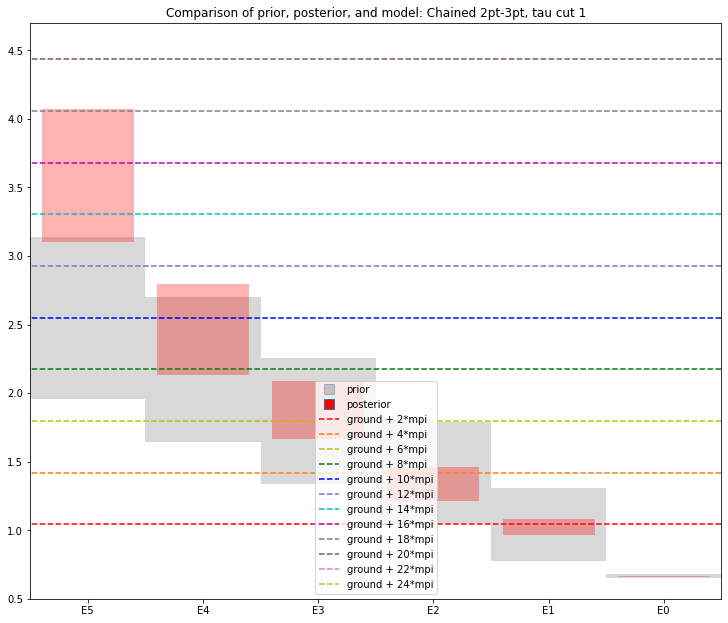

[0 1 2 3 4 5]
[0.66041814 1.00107251 1.32841552 1.94560087 2.27433339 2.62721227]
[[0.4 0.4 0.4 0.4 0.4 0.4]
 [0.4 0.4 0.4 0.4 0.4 0.4]]
[[0.00281083 0.06107869 0.13677092 0.26753746 0.32866206 0.40561681]
 [0.00281083 0.06107869 0.13677092 0.26753746 0.32866206 0.40561681]]


<Figure size 432x288 with 0 Axes>

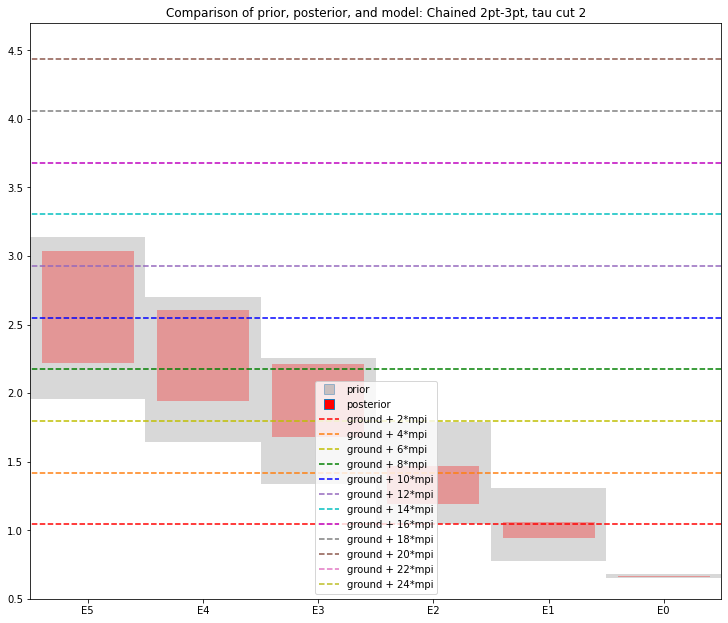

[ 0  1  2  3  4  5 -1]
[0.66038044 0.99524174 1.32863509 1.92763998 2.54427749 3.68507266
 1.47154648]
[[0.4 0.4 0.4 0.4 0.4 0.4 0.5]
 [0.4 0.4 0.4 0.4 0.4 0.4 0.5]]
[[0.00248183 0.0432967  0.11167196 0.19833988 0.33861991 0.51353381
  0.04372428]
 [0.00248183 0.0432967  0.11167196 0.19833988 0.33861991 0.51353381
  0.04372428]]


<Figure size 432x288 with 0 Axes>

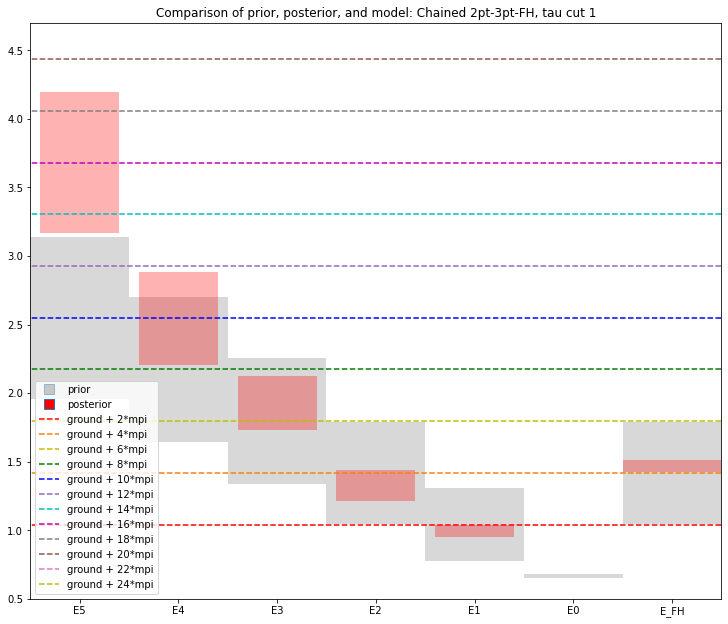

[ 0  1  2  3  4  5 -1]
[0.65932845 0.98227373 1.32679491 2.01214368 2.33312022 2.68551672
 1.48829885]
[[0.4 0.4 0.4 0.4 0.4 0.4 0.5]
 [0.4 0.4 0.4 0.4 0.4 0.4 0.5]]
[[0.00252234 0.04368753 0.11828731 0.26437085 0.3279082  0.40655288
  0.04577573]
 [0.00252234 0.04368753 0.11828731 0.26437085 0.3279082  0.40655288
  0.04577573]]


<Figure size 432x288 with 0 Axes>

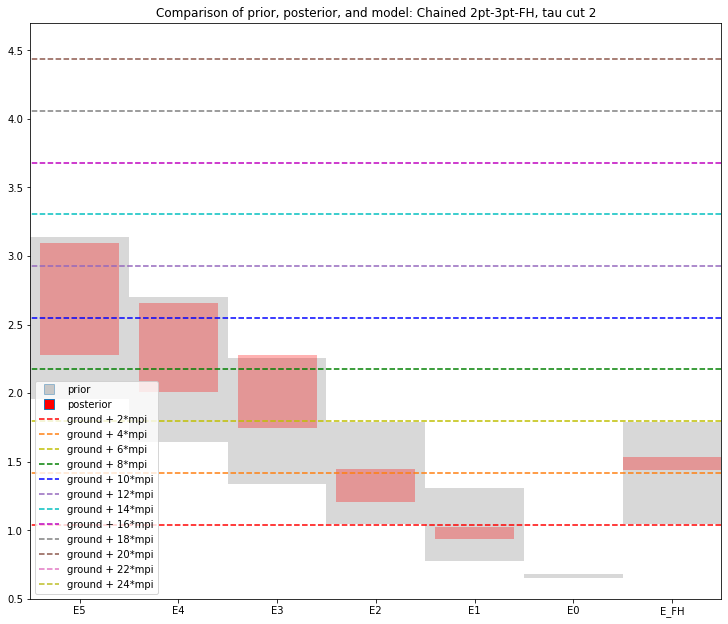

<Figure size 432x288 with 0 Axes>

In [27]:

fig = plt.figure(figsize=(12, 10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
spectrum_graph(6, 0, 'chained_2pt_3pt_tau1_Final.obj', 'chained_2pt_3pt_tau1_espectrum.png', "Comparison of prior, posterior, and model: Chained 2pt-3pt, tau cut 1", 0.7)

fig = plt.figure(figsize=(12, 10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
spectrum_graph(6, 0, 'chained_2pt_3pt_tau2_Final.obj', 'chained_2pt_3pt_tau2_espectrum.png', "Comparison of prior, posterior, and model: Chained 2pt-3pt, tau cut 2", 0.7)

fig = plt.figure(figsize=(12, 10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
spectrum_graph(6, 3, 'chained_2pt_3pt_FH_tau1_Final.obj', 'chained_2pt_3pt_FH_tau1_espectrum.png', "Comparison of prior, posterior, and model: Chained 2pt-3pt-FH, tau cut 1", 0.7)

fig = plt.figure(figsize=(12, 10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
spectrum_graph(6, 3, 'chained_2pt_3pt_FH_tau2_Final.obj', 'chained_2pt_3pt_FH_tau2_espectrum.png', "Comparison of prior, posterior, and model: Chained 2pt-3pt-FH, tau cut 2", 0.7)


### Simultaneous 2pt-3pt fit

[0 1 2 3 4 5]
[0.6607429  0.97178586 1.2554064  1.68880279 2.38685765 3.52450812]
[[0.4 0.4 0.4 0.4 0.4 0.4]
 [0.4 0.4 0.4 0.4 0.4 0.4]]
[[0.00378836 0.11302572 0.145322   0.18201191 0.28786916 0.46116908]
 [0.00378836 0.11302572 0.145322   0.18201191 0.28786916 0.46116908]]


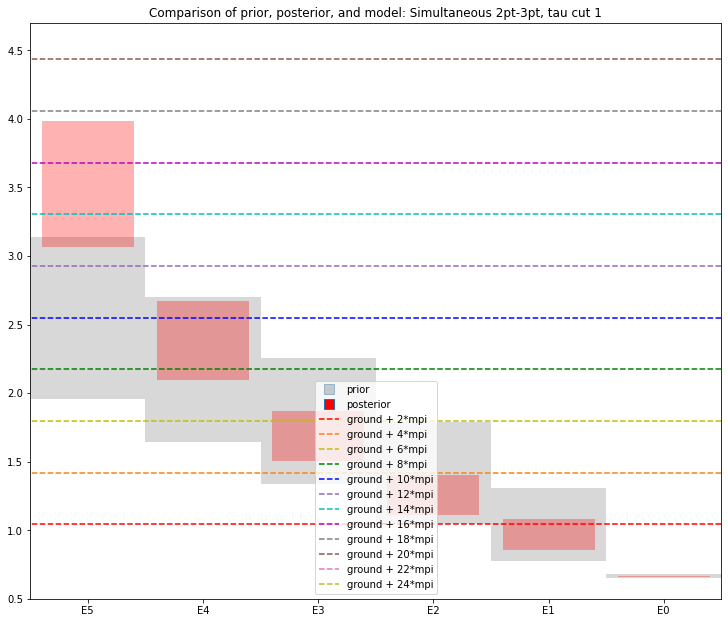

[0 1 2 3 4 5]
[0.6594939  0.91254727 1.20932479 1.61150057 2.06775906 2.44562087]
[[0.4 0.4 0.4 0.4 0.4 0.4]
 [0.4 0.4 0.4 0.4 0.4 0.4]]
[[0.00437123 0.11916585 0.13769227 0.23611122 0.25903389 0.33075301]
 [0.00437123 0.11916585 0.13769227 0.23611122 0.25903389 0.33075301]]


<Figure size 432x288 with 0 Axes>

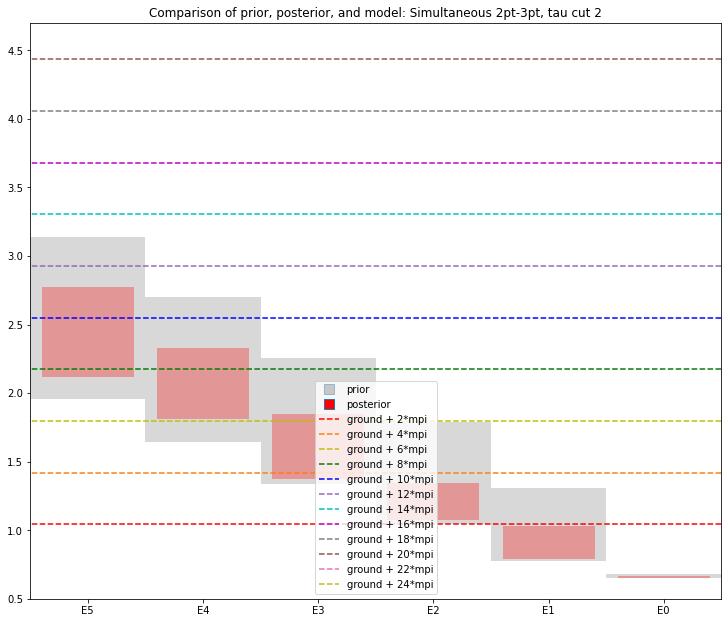

[ 0  1  2  3  4  5 -1]
[0.66089976 1.0383469  1.36661097 1.80591029 2.47128365 3.67571672
 1.72625893]
[[0.4 0.4 0.4 0.4 0.4 0.4 0.5]
 [0.4 0.4 0.4 0.4 0.4 0.4 0.5]]
[[0.00302203 0.06192309 0.14930681 0.19839233 0.31934574 0.51184651
  0.15430636]
 [0.00302203 0.06192309 0.14930681 0.19839233 0.31934574 0.51184651
  0.15430636]]


<Figure size 432x288 with 0 Axes>

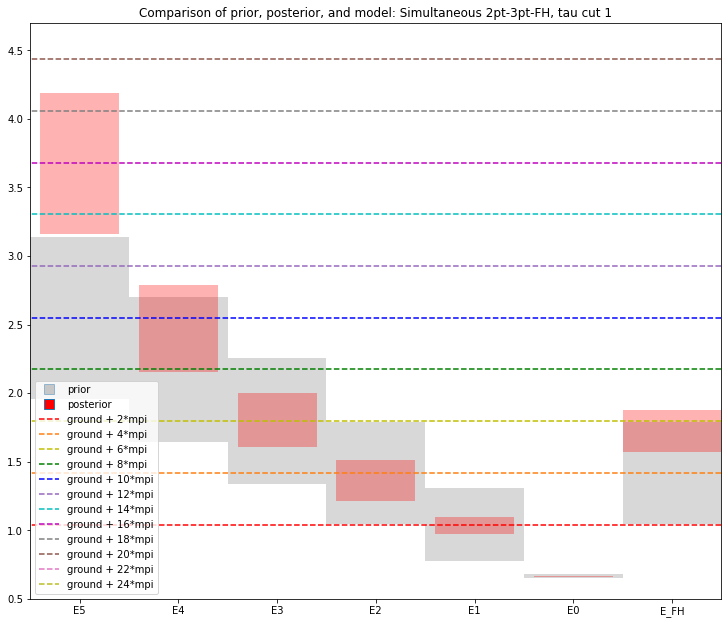

[ 0  1  2  3  4  5 -1]
[0.659454   0.98325502 1.29345534 1.76718508 2.15442537 2.50192607
 1.71570263]
[[0.4 0.4 0.4 0.4 0.4 0.4 0.5]
 [0.4 0.4 0.4 0.4 0.4 0.4 0.5]]
[[0.00363477 0.07591603 0.1264049  0.22519873 0.25148005 0.32272592
  0.16277402]
 [0.00363477 0.07591603 0.1264049  0.22519873 0.25148005 0.32272592
  0.16277402]]


<Figure size 432x288 with 0 Axes>

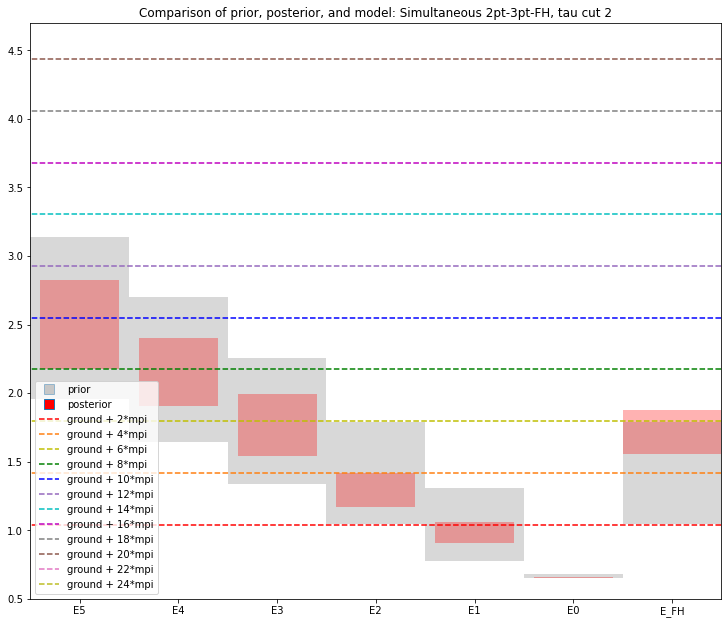

<Figure size 432x288 with 0 Axes>

In [28]:

fig = plt.figure(figsize=(12, 10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
spectrum_graph(6, 0, 'simultaneous_2pt_3pt_tau1_Final.obj', 'simultaneous_2pt_3pt_tau1_espectrum.png', "Comparison of prior, posterior, and model: Simultaneous 2pt-3pt, tau cut 1", 0.7)

fig = plt.figure(figsize=(12, 10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
spectrum_graph(6, 0, 'simultaneous_2pt_3pt_tau2_Final.obj', 'simultaneous_2pt_3pt_tau1_espectrum.png', "Comparison of prior, posterior, and model: Simultaneous 2pt-3pt, tau cut 2", 0.7)

fig = plt.figure(figsize=(12, 10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
spectrum_graph(6, 3, 'simultaneous_2pt_3pt_FH_tau1_Final.obj', 'simultaneous_2pt_3pt_FH_tau1_espectrum.png', "Comparison of prior, posterior, and model: Simultaneous 2pt-3pt-FH, tau cut 1", 0.7)

fig = plt.figure(figsize=(12, 10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
spectrum_graph(6, 3, 'simultaneous_2pt_3pt_FH_tau2_Final.obj', 'simultaneous_2pt_3pt_FH_tau2_espectrum.png', "Comparison of prior, posterior, and model: Simultaneous 2pt-3pt-FH, tau cut 2", 0.7)



### Chained 2pt-sumsub-3pt fit

[ 0  1  2  3  4  5 -1]
[0.66192769 1.03531023 1.35956962 1.91200205 2.49926305 3.61419844
 1.584387  ]
[[0.4 0.4 0.4 0.4 0.4 0.4 0.5]
 [0.4 0.4 0.4 0.4 0.4 0.4 0.5]]
[[0.00267535 0.05790095 0.11463913 0.21005903 0.32947481 0.48850538
  0.26816227]
 [0.00267535 0.05790095 0.11463913 0.21005903 0.32947481 0.48850538
  0.26816227]]


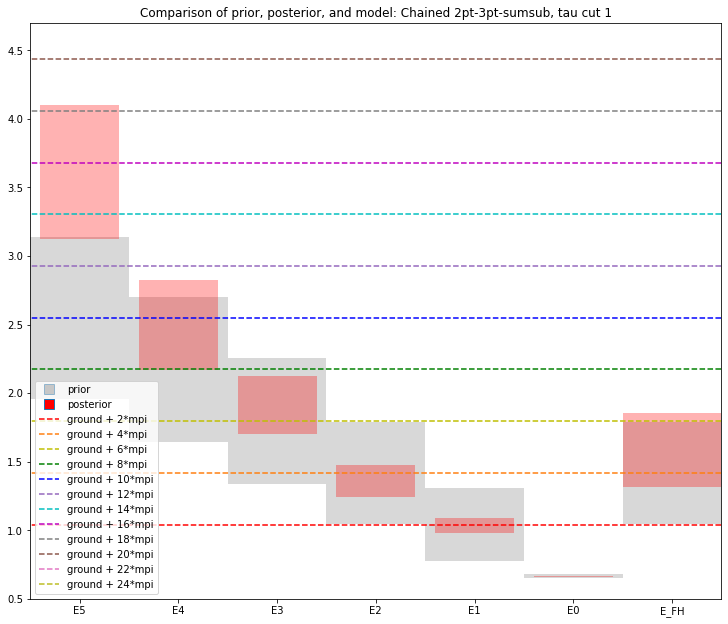

[ 0  1  2  3  4  5 -1]
[0.66050983 0.99836424 1.31847966 1.93032364 2.25601821 2.606577
 1.62668331]
[[0.4 0.4 0.4 0.4 0.4 0.4 0.5]
 [0.4 0.4 0.4 0.4 0.4 0.4 0.5]]
[[0.00283227 0.06017704 0.13283933 0.26293772 0.31986494 0.39725168
  0.3171392 ]
 [0.00283227 0.06017704 0.13283933 0.26293772 0.31986494 0.39725168
  0.3171392 ]]


<Figure size 432x288 with 0 Axes>

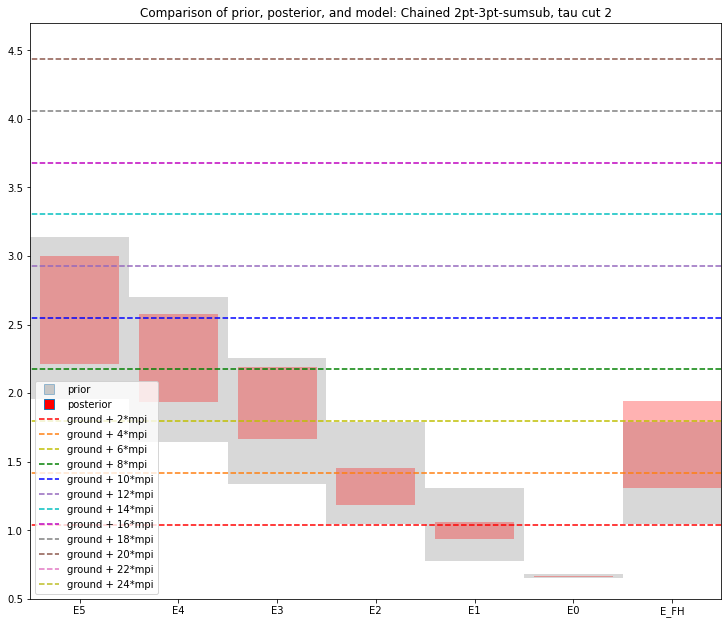

[ 0  1  2  3  4  5 -1]
[0.65918655 1.02051713 1.43928203 1.96281168 2.58885606 3.72358105
 1.50186482]
[[0.4 0.4 0.4 0.4 0.4 0.4 0.5]
 [0.4 0.4 0.4 0.4 0.4 0.4 0.5]]
[[0.00240563 0.03990234 0.11248124 0.21258373 0.36193505 0.53442723
  0.04642869]
 [0.00240563 0.03990234 0.11248124 0.21258373 0.36193505 0.53442723
  0.04642869]]


<Figure size 432x288 with 0 Axes>

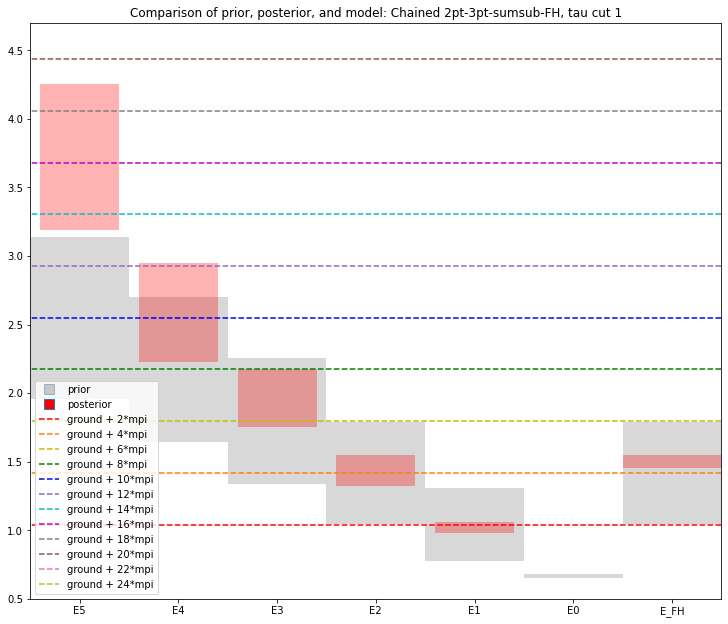

[ 0  1  2  3  4  5 -1]
[0.65831961 1.01805214 1.47307805 2.06823544 2.40138684 2.76266284
 1.5254753 ]
[[0.4 0.4 0.4 0.4 0.4 0.4 0.5]
 [0.4 0.4 0.4 0.4 0.4 0.4 0.5]]
[[0.00245663 0.04085866 0.12502977 0.27129041 0.34273168 0.42251303
  0.0501662 ]
 [0.00245663 0.04085866 0.12502977 0.27129041 0.34273168 0.42251303
  0.0501662 ]]


<Figure size 432x288 with 0 Axes>

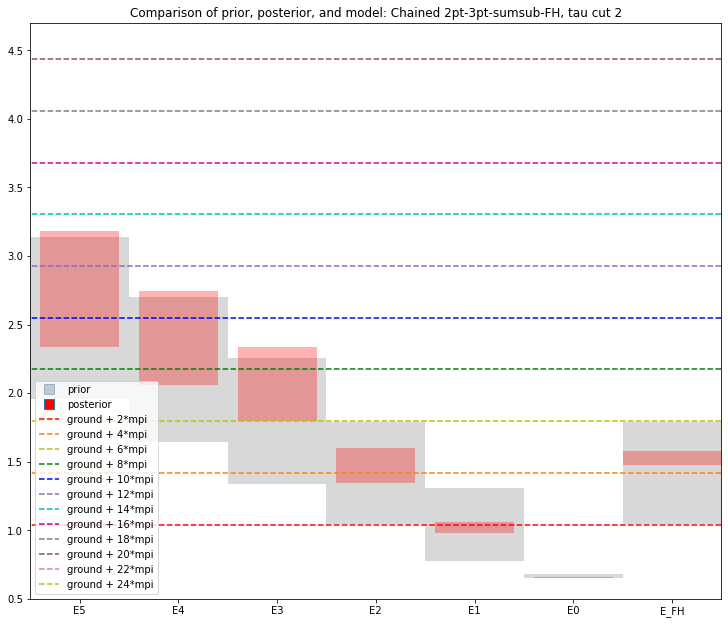

<Figure size 432x288 with 0 Axes>

In [29]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
spectrum_graph(6, 3, "chained_2pt_3pt_sumsub_tau1_Final.obj", 'chained_2pt_3pt_sumsub_tau1_espectrum.png', "Comparison of prior, posterior, and model: Chained 2pt-3pt-sumsub, tau cut 1", 0.7)

fig = plt.figure(figsize=(12, 10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
spectrum_graph(6, 3, 'chained_2pt_3pt_sumsub_tau2_Final.obj', 'chained_2pt_3pt_sumsub_tau2_espectrum.png', "Comparison of prior, posterior, and model: Chained 2pt-3pt-sumsub, tau cut 2", 0.7)

fig = plt.figure(figsize=(12, 10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
spectrum_graph(6, 3, 'chained_2pt_3pt_sumsub_FH_tau1_Final.obj', 'chained_2pt_3pt_sumsub_FH_tau1_espectrum.png', "Comparison of prior, posterior, and model: Chained 2pt-3pt-sumsub-FH, tau cut 1", 0.7)

fig = plt.figure(figsize=(12, 10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
spectrum_graph(6, 3, 'chained_2pt_3pt_sumsub_FH_tau2_Final.obj', 'chained_2pt_3pt_sumsub_FH_tau2_espectrum.png', "Comparison of prior, posterior, and model: Chained 2pt-3pt-sumsub-FH, tau cut 2", 0.7)



[ 0  1  2  3  4  5 -1]
[0.65974856 1.05466383 1.43159712 1.97087084 2.52755456 3.67877911
 1.37202481]
[[0.4 0.4 0.4 0.4 0.4 0.4 0.5]
 [0.4 0.4 0.4 0.4 0.4 0.4 0.5]]
[[0.00054609 0.04554181 0.08573216 0.17010701 0.2826608  0.42927254
  0.10302028]
 [0.00054609 0.04554181 0.08573216 0.17010701 0.2826608  0.42927254
  0.10302028]]


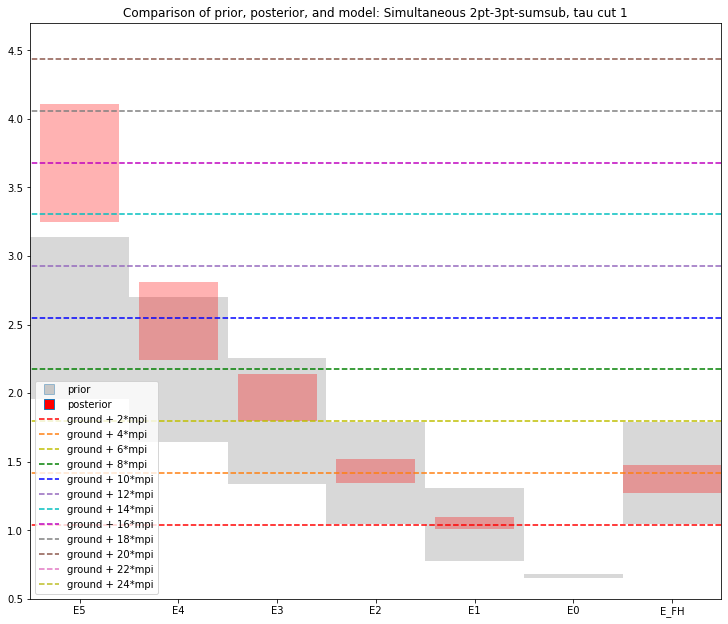

[ 0  1  2  3  4  5 -1]
[0.66037572 0.9780372  1.26578744 1.6829997  2.12831378 2.49466603
 1.51558865]
[[0.4 0.4 0.4 0.4 0.4 0.4 0.5]
 [0.4 0.4 0.4 0.4 0.4 0.4 0.5]]
[[0.00366081 0.09341059 0.14852019 0.23709964 0.2736949  0.3367575
  0.26289552]
 [0.00366081 0.09341059 0.14852019 0.23709964 0.2736949  0.3367575
  0.26289552]]


<Figure size 432x288 with 0 Axes>

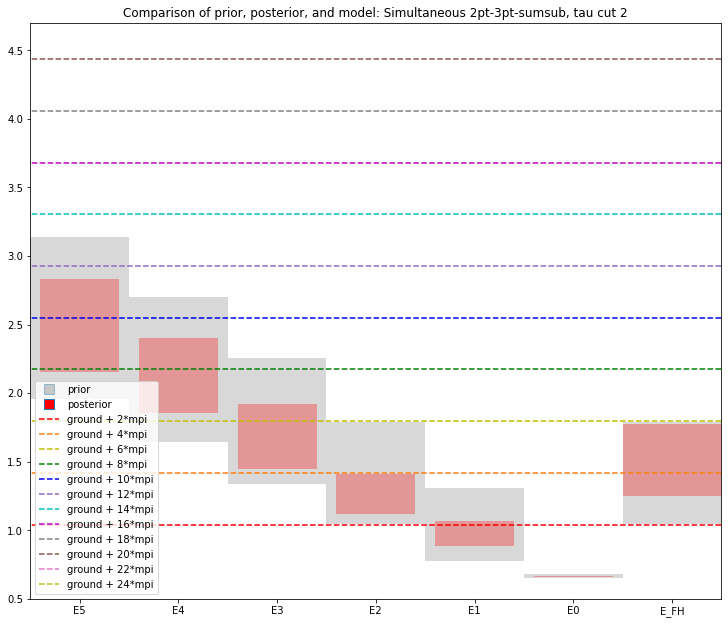

[ 0  1  2  3  4  5 -1]
[0.65771463 0.95496179 1.23990776 1.6120436  2.39925417 3.79912665
 1.49192929]
[[0.4 0.4 0.4 0.4 0.4 0.4 0.5]
 [0.4 0.4 0.4 0.4 0.4 0.4 0.5]]
[[0.00112766 0.05064623 0.07161619 0.09445264 0.20377154 0.48994079
  0.08099102]
 [0.00112766 0.05064623 0.07161619 0.09445264 0.20377154 0.48994079
  0.08099102]]


<Figure size 432x288 with 0 Axes>

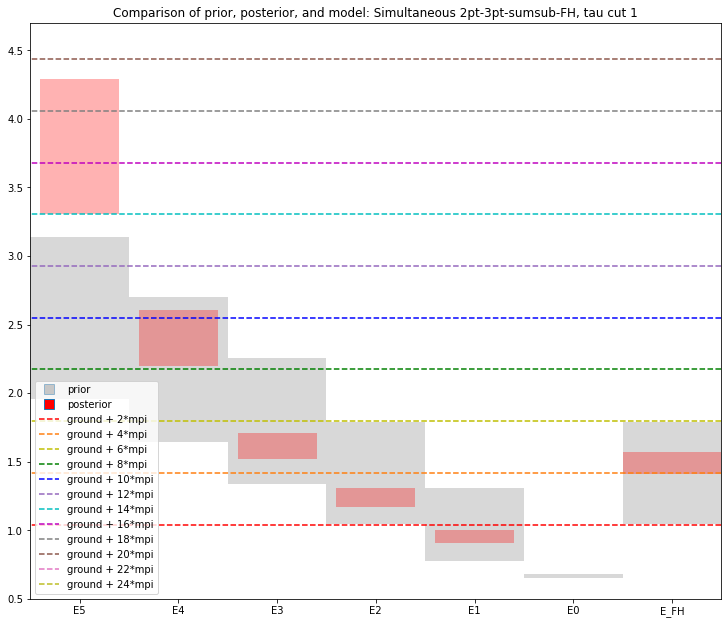

[ 0  1  2  3  4  5 -1]
[0.66097628 1.02825401 1.32338161 1.73062569 2.16332004 2.52900524
 1.71768953]
[[0.4 0.4 0.4 0.4 0.4 0.4 0.5]
 [0.4 0.4 0.4 0.4 0.4 0.4 0.5]]
[[0.00275361 0.05273838 0.14671288 0.22956044 0.27108011 0.33801141
  0.13759211]
 [0.00275361 0.05273838 0.14671288 0.22956044 0.27108011 0.33801141
  0.13759211]]


<Figure size 432x288 with 0 Axes>

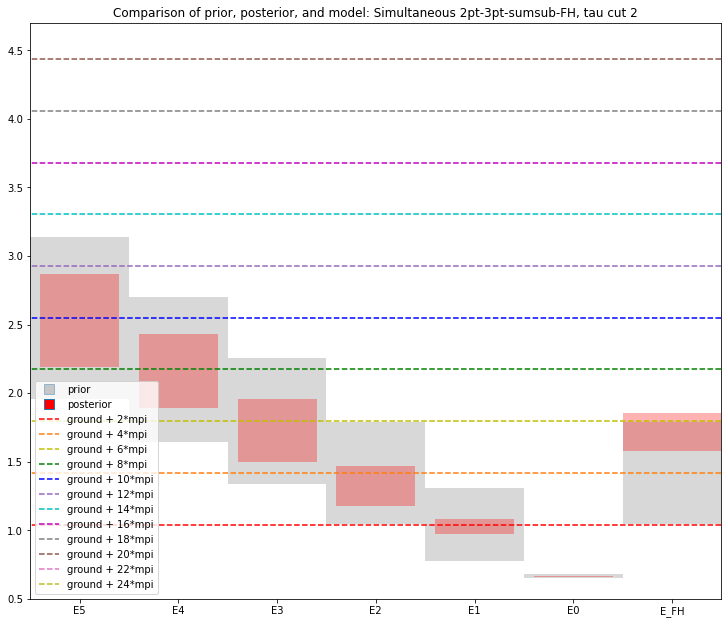

<Figure size 432x288 with 0 Axes>

In [30]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
spectrum_graph(6, 3, "simultaneous_2pt_3pt_sumsub_tau1_Final.obj", 'simultaneous_2pt_3pt_sumsub_tau1_espectrum.png', "Comparison of prior, posterior, and model: Simultaneous 2pt-3pt-sumsub, tau cut 1", 0.7)

fig = plt.figure(figsize=(12, 10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
spectrum_graph(6, 3, 'simultaneous_2pt_3pt_sumsub_tau2_Final.obj', 'simultaneous_2pt_3pt_sumsub_tau2_espectrum.png', "Comparison of prior, posterior, and model: Simultaneous 2pt-3pt-sumsub, tau cut 2", 0.7)

fig = plt.figure(figsize=(12, 10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
spectrum_graph(6, 3, 'simultaneous_2pt_3pt_sumsub_FH_tau1_Final.obj', 'simultaneous_2pt_3pt_sumsub_FH_tau1_espectrum.png', "Comparison of prior, posterior, and model: Simultaneous 2pt-3pt-sumsub-FH, tau cut 1", 0.7)

fig = plt.figure(figsize=(12, 10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
spectrum_graph(6, 3, 'simultaneous_2pt_3pt_sumsub_FH_tau2_Final.obj', 'simultaneous_2pt_3pt_sumsub_FH_tau2_espectrum.png', "Comparison of prior, posterior, and model: Simultaneous 2pt-3pt-sumsub-FH, tau cut 2", 0.7)
